In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:26<00:00, 20.2MB/s]
100% 675M/675M [00:26<00:00, 26.9MB/s]


In [7]:
!mkdir iarunava

In [8]:
! unzip cell-images-for-detecting-malaria.zip -d iarunava

Streaming output truncated to the last 5000 lines.
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: iarunava/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: iarunava/cell_imag

In [9]:
import os
import pandas as pd
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

def prep_dataset(X,y):
    X_prep = X.astype('float32')
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [10]:
root = '/content/iarunava/cell_images/'
para = '/Parasitized/'
uninf = '/Uninfected/'

os.listdir(root)

['cell_images', 'Parasitized', 'Uninfected']

In [11]:
Parasitized = os.listdir(root+para)
Uninfected = os.listdir(root+uninf)

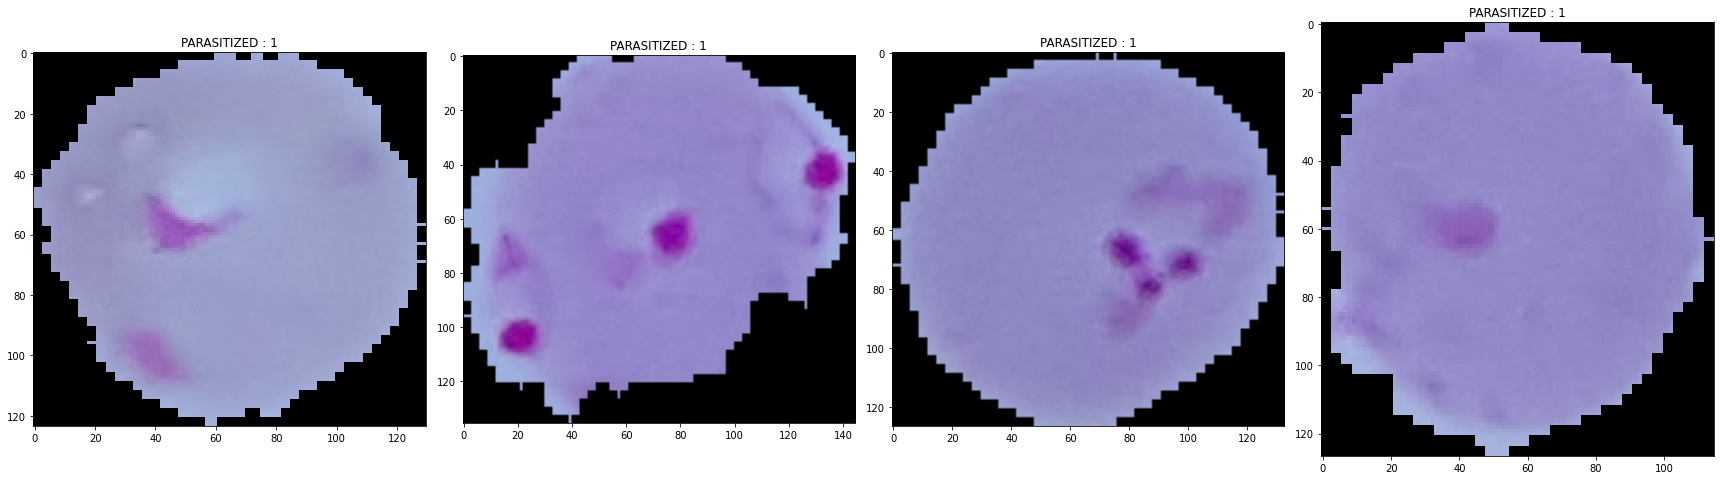

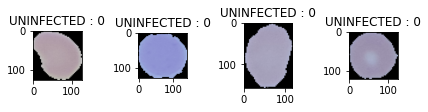

In [12]:
plt.figure(figsize = (24,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(root+para+ Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(root+uninf+ Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

In [13]:
data = []
labels = []

for img in Parasitized:
    try:
        img_read = plt.imread(root+para+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in Uninfected:
    try:
        img_read = plt.imread(root+uninf+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

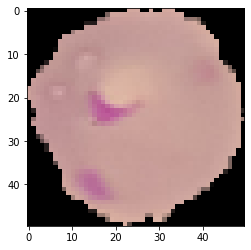

In [14]:
plt.imshow(data[0], cmap='gray')
plt.show()

In [15]:
image_data = np.array(data)
labels = np.array(labels)

idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [16]:
image_data.shape

(27558, 50, 50, 3)

In [17]:
labels.shape

(27558,)

In [18]:
X, y = prep_dataset(image_data,labels)

In [19]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=y)
X_ts, X_val, Y_ts, Y_val = train_test_split(X_ts,Y_ts, test_size=0.5, stratify=Y_ts)

Y_ts = np.argmax(Y_ts, axis=1)

In [20]:
model = models.Sequential()

#Input + Conv 1 + ReLU + Max Pooling
model.add(layers.Conv2D(filters=4,kernel_size=3,activation='relu',input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())


# Conv 2 + ReLU + Max Pooling
model.add(layers.Conv2D(filters=16,kernel_size=3,activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())


# Conv 3 + ReLU + Max Pooling
model.add(layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())


# Fully Connected + ReLU
model.add(layers.Conv2D(filters=4,kernel_size=1,activation='relu'))
model.add(layers.Flatten())

#Output
model.add(layers.Dense(2, activation='softmax'))


model.summary()

# 95.64%

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          9

In [21]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',mode='max',patience=5,verbose=1)

history= model.fit(X_tr,Y_tr,
                 epochs=100,
                 batch_size=50,
                 validation_data=(X_val,Y_val),
                 callbacks=[es])

Epoch 1/100
441/441 [==============================] - 30s 65ms/step - loss: 0.5301 - accuracy: 0.7330 - val_loss: 0.5941 - val_accuracy: 0.6840
Epoch 2/100
441/441 [==============================] - 31s 70ms/step - loss: 0.2055 - accuracy: 0.9243 - val_loss: 0.1869 - val_accuracy: 0.9372
Epoch 3/100
441/441 [==============================] - 29s 65ms/step - loss: 0.1607 - accuracy: 0.9439 - val_loss: 0.1641 - val_accuracy: 0.9459
Epoch 4/100
441/441 [==============================] - 28s 65ms/step - loss: 0.1355 - accuracy: 0.9524 - val_loss: 0.1546 - val_accuracy: 0.9463
Epoch 5/100
441/441 [==============================] - 29s 65ms/step - loss: 0.1261 - accuracy: 0.9552 - val_loss: 0.1487 - val_accuracy: 0.9499
Epoch 6/100
441/441 [==============================] - 29s 65ms/step - loss: 0.1209 - accuracy: 0.9563 - val_loss: 0.1481 - val_accuracy: 0.9496
Epoch 7/100
441/441 [==============================] - 29s 65ms/step - loss: 0.1175 - accuracy: 0.9571 - val_loss: 0.1456 - val_ac

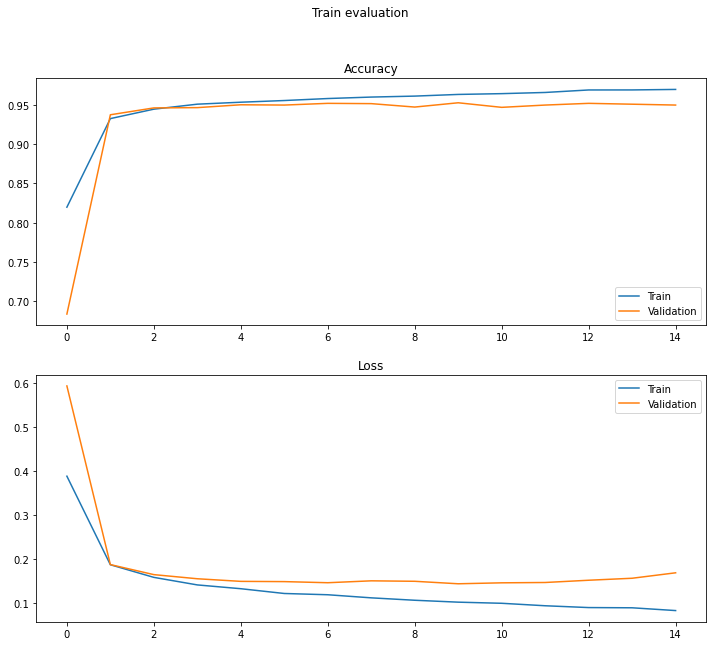

In [22]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')


plt.show()

In [23]:
Y_pred = model.predict(X_ts)

Y_pred = np.argmax(Y_pred, axis=1)

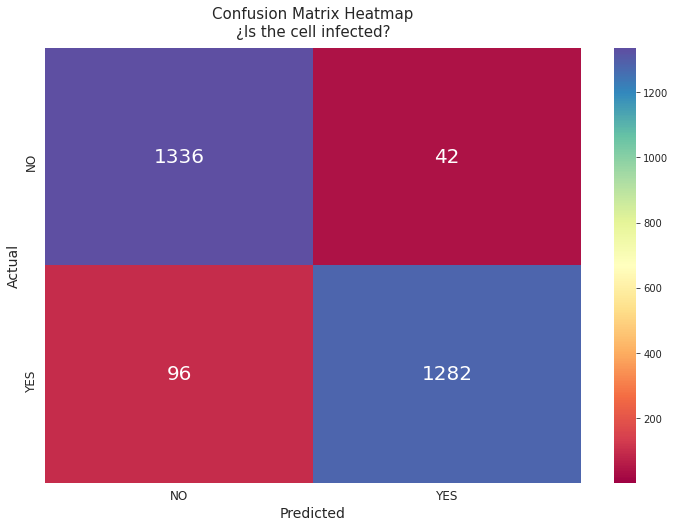

-Acuracy achieved: 94.99%
-Accuracy by model was: 96.94%
-Accuracy by validation was: 94.96%


In [24]:
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n¿Is the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
plt.show()


print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

In [25]:
index=0
index_errors= []

for label, predict in zip(Y_ts,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1

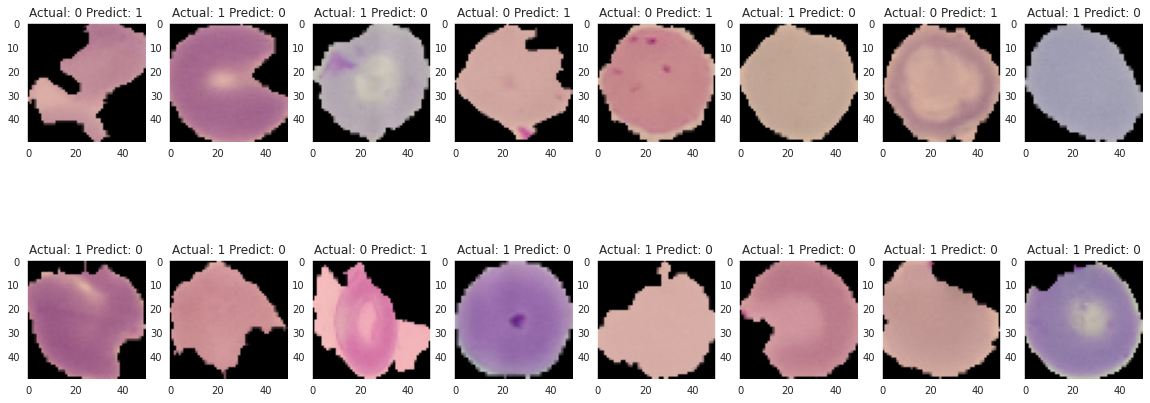

In [26]:
plt.figure(figsize=(20,8))

for i,img_index in zip(range(1,17),random.sample(index_errors,k=18)):
    plt.subplot(2,8,i)
    plt.imshow(np.reshape(X_ts[img_index], (50,50,3)))
    plt.title('Actual: '+str(Y_ts[img_index])+' Predict: '+str(Y_pred[img_index]))
plt.show()

In [27]:
model.save("malaria_detector.h5")